<a href="https://colab.research.google.com/github/ooeyad/utterance_Gender_Classifier/blob/master/gender_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imoprt Required Libraries

In [1]:
pip install colorednoise

  Created wheel for colorednoise: filename=colorednoise-1.1.1-cp36-none-any.whl size=3958 sha256=67475483fdcc64234dac04a896a142bdb440e5c561bcea13f1b9766ec6e75ef4
  Stored in directory: /root/.cache/pip/wheels/84/be/f3/3e7e1c80ebab3f6f0dbd3e34e787b902d2280d66706485fef4
Successfully built colorednoise


In [402]:
import librosa
import librosa.display


import scipy
# import scipy.io.wavfile
import numpy as np
import pandas as pd

import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation,TimeDistributed,Conv1D,MaxPooling1D,LSTM,Flatten,Conv2D,AveragePooling1D, AveragePooling2D, MaxPooling2D, BatchNormalization, GRU
from keras.callbacks import EarlyStopping, ModelCheckpoint

import tarfile
import os

from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split , KFold , cross_val_score
from sklearn.metrics import accuracy_score,f1_score, fbeta_score

import xgboost

import IPython

from keras.models import model_from_json

from google.colab import drive

import shutil


# Colored Noise
import colorednoise as cn

import pickle

from keras.callbacks import LearningRateScheduler

import math

from joblib import dump, load

%matplotlib inline

Mount my Google Drive

In [ ]:
drive.mount('/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /drive


Some constants

In [403]:
ROOT_DIR = '/content'
number_of_mfcc = 40
frames = 87
genders = ['M','F']
duration = 2 #seconds

DATA_SOURCE = 'D' # Read files from the drive, to read data from crawled files again set it as 'U'
CRAWL_DATA = False # set to true if you need to recrawl data from source website.
MODEL_OPTION = 1
# set your own google drive path where you need to save and later extract data
drive_path = '/content/drive/My Drive/classification'

STAT_COLUMNS = ['tonnetz_max',
                'tonnetz_std',
                'sc_max',
                's_cent_min',
                'sb_mean',
                'rmse_max',
                'rmse_std',
                'roll_off_mean',
                'rmse_mean',
                'tonnetz_mean',
                's_cent_mean',
                'zero_crossing_min',
                'sc_mean',
                'sf_mean',
                'sf_max',
                'zero_crossing_mean',
                'tonnetz_min',
                'sf_std',
                'roll_off_std',
                'rmse_min',
                'sb_min',
                'sc_std',
                'roll_off_max',
                'roll_off_min',
                's_cent_max',
                'sb_std',
                'sb_max',
                'zero_crossing_max']

Crawl required data and extract them, then do transformation using different techniques.

In [458]:
# extract speakers data from  speakers.txt file included in the files
def get_speakers_info(file_path,sub_path_name):
  ids = []
  genders = []
  minutes = []
  with open(file_path) as f:
    for line in f:
      if sub_path_name in line:
        l = line.strip().split('|')
        ids.append(l[0].strip())
        genders.append(l[1].strip())
        minutes.append(l[3])
  speakers_info = pd.DataFrame({'ID':ids,'SEX':genders,'MINUTES':minutes})
  speakers_info['ID'] = speakers_info['ID'].astype('int')
  return speakers_info

# get only speakers that have sound files in the extracted base_path.
def get_existing_list(speakers_df,base_path):
  id_list = os.listdir(base_path)
  id_list = np.array(id_list).astype('int64')
  id_list_df = pd.DataFrame(id_list)
  id_list_df.columns = ['ID']
  id_list_df = pd.merge(left=id_list_df,right=speakers_df,left_on = 'ID',right_on='ID')
  
  return id_list_df

# prepare dictionary of speakers with their list of utterance files paths
def prepare_files_list(files_list,base_path):
  sound_info = {}
  for id in files_list:
    ids_audio_data = []
    dir_list = os.listdir(os.path.join(base_path,str(id)))
    for sub in dir_list:
      files_list = os.listdir(os.path.join(os.path.join(base_path,str(id)),sub))
      for file_name in files_list:
        # try:
        #   data,sample_rate = librosa.load(os.path.join(os.path.join(os.path.join(base_path,str(id)),sub),file_name))
        #   sound_details = spectral_properties(data, sample_rate) 
        # except:
        #   pass
        if (file_name[-4:] == 'flac' or file_name[-3:] == 'wav'):
          ids_audio_data.append(os.path.join(os.path.join(os.path.join(base_path,str(id)),sub),file_name))
    sound_info[id] = ids_audio_data
  return sound_info
# prepare dataframe of speakers with their list of utterance files paths 
# files_per_speaker defines maximum number of files to extract for each speaker.

def prepare_files_dataframe(base_path, speakers_df,max_files_per_speaker = 40):
  # base_path = ROOT_DIR + '/train_clean/LibriSpeech/train-clean-100'

  id_list_df = get_existing_list(speakers_df,base_path)
  all_data = prepare_files_list(id_list_df['ID'].values,base_path)

  ids_list = []
  files_list = []
  for key in all_data:
    # only take maximum 40 files from each speaker
    cnt = 0
    for f in all_data[key]:
      if cnt <max_files_per_speaker:
        ids_list.append(key)
        files_list.append(f)
        cnt += 1
      else:
        break
      

  d = {'ID':ids_list,'file':files_list}
  files_df = pd.DataFrame(d)

  files_df = pd.merge(left=files_df,right=speakers_df,how='inner',left_on='ID',right_on='ID')

  return files_df



# Audio Files Augmentation
# augment by pitch change
def pitch_change(data, sampling_rate, pitch_factor):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)
# add white noise
def inject_noise(data, noise_factor):
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    # Cast back to same data type
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data
# add colored noise
def inject_noise2(data, noise_factor):
    beta = 1 # the exponent
    samples = len(data) # number of samples to generate
    y = cn.powerlaw_psd_gaussian(beta, samples)
    augmented_data = data + noise_factor * y
    # Cast back to same data type
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data
# generate augmented audio file from a given file and save in the base_dir
def generate_augmented_sound(base_dir,file_name, src_data ,sampling_rate , pitch_factor = .005, noise_type = 1 ):
  file_path = os.path.join(ROOT_DIR,base_dir)

  # src_data,src_rate = librosa.load(wav_loc,duration=3)
  s_data = pitch_change(src_data , sampling_rate , pitch_factor)
  if noise_type == 1:
    s_data = inject_noise(s_data,.02)
  else:
    s_data = inject_noise2(s_data,.02)
  spectrum = librosa.stft(s_data)
  reconstructed_audio = librosa.istft(spectrum)
  librosa.output.write_wav(base_dir + '/' + file_name, reconstructed_audio, sampling_rate, norm=False)

# delete augmented files
def delete_augmented_data(aug_dir):
  try:
      if os.path.join(ROOT_DIR,aug_dir):
        shutil.rmtree(os.path.join(ROOT_DIR,aug_dir))
  except OSError as e:
      print("Error: %s : %s" % (aug_dir, e.strerror))

# generate random augmented audio files and save them to noisy_data directory 
def augment_random_sound_files(df,aug_rate):
  dir_male = ROOT_DIR + '/' + 'noisy_data/male'
  os.makedirs(dir_male) 
  dir_female = ROOT_DIR + '/' + 'noisy_data/female'
  os.makedirs(dir_female) 

  df = shuffle(df)
  aug_size = int(aug_rate * df.shape[0])

  aug_df = df[0:aug_size].reset_index(drop=True)

  # after getting rnadom sound files we need to augment them in different files
  for i in range(aug_df.shape[0]):
    sound_file = aug_df.iloc[i]['file']
    if aug_df.iloc[i]['SEX'] == 'M':
      b_dir = dir_male
      file_name = str(i) + '.wav'
    elif aug_df.iloc[i]['SEX'] == 'F':
      b_dir = dir_female 
      file_name = str(i) + '.wav'
    
    src_data, sampling_rate = librosa.load(aug_df.iloc[i]['file'])
    if np.random.randint(0, 100) % 2 == 0:
      noise_type = 1
    else:
      noise_type = 2
      
    generate_augmented_sound(b_dir,file_name, src_data ,sampling_rate,noise_type=noise_type)

# get augmented data in a dataframe.
def prepare_augmented_df(base_path,drive_path,url_file_selection = 'U'):
  if url_file_selection == 'U':
    dir_list = os.listdir(os.path.join(ROOT_DIR,base_path))
    female_list = []
    male_list = []
    for d in dir_list:
      for f in os.listdir(os.path.join(os.path.join(ROOT_DIR,base_path),d)):
        if d == 'female':
          female_list.append(os.path.join(os.path.join(os.path.join(ROOT_DIR,base_path),d),f))
        elif d == 'male':
          male_list.append(os.path.join(os.path.join(os.path.join(ROOT_DIR,base_path),d),f))
    
    female_df = pd.DataFrame({'ID':np.zeros(len(female_list)),'file':np.array(female_list)})
    male_df = pd.DataFrame({'ID':np.ones(len(female_list)),'file':np.array(female_list)})

    female_df['SEX'] = 'F'
    male_df['SEX'] = 'M'

    female_df['MINUTES'] = '00:15'
    male_df['MINUTES'] = '00:15'

  elif url_file_selection == 'D':
    dir_list = os.listdir(os.path.join(drive_path,base_path))
    female_list = []
    male_list = []
    for d in dir_list:
      for f in os.listdir(os.path.join(os.path.join(drive_path,base_path),d)):
        if d == 'female':
          female_list.append(os.path.join(os.path.join(os.path.join(drive_path,base_path),d),f))
        elif d == 'male':
          male_list.append(os.path.join(os.path.join(os.path.join(drive_path,base_path),d),f))
    
    female_df = pd.DataFrame({'ID':np.zeros(len(female_list)),'file':np.array(female_list)})
    male_df = pd.DataFrame({'ID':np.ones(len(female_list)),'file':np.array(female_list)})

    female_df['SEX'] = 'F'
    male_df['SEX'] = 'M'

    female_df['MINUTES'] = '00:15'
    male_df['MINUTES'] = '00:15'

  

  df = pd.concat([female_df,male_df],axis=0).reset_index(drop=True)

  return df

# concatenate dfs
def concat_augmented_df(clean_df , aug_df):
  return pd.concat([clean_df,aug_df],axis=0).reset_index(drop=True)

# Process a sound file using MFCC
def get_mfcc_properties(signal_data,sr):
  signal = signal_data
  # pad signals of max seconds duration
  signal_length = duration * sr
  length = signal.shape[0]
  pad_length = signal_length - length
  if pad_length > 0:
    padding = np.zeros(pad_length)
    signal = np.hstack((signal, padding))
  mfcc_feats = librosa.feature.mfcc(signal, sr, n_mfcc=number_of_mfcc)

  return mfcc_feats


# get energy levels of signal
def get_energy_levels(signal_data,sr):
  signal = signal_data
  signal_length = duration * sr
  length = signal.shape[0]
  pad_length = signal_length - length
  if pad_length > 0:
    padding = np.zeros(pad_length)
    signal = np.hstack((signal, padding))
  X = librosa.stft(signal)
  #converting into energy levels(dB)
  Xdb = librosa.amplitude_to_db(abs(X))
  return Xdb

# signals statistical information of sepctral and frequencies features.
def get_signal_stats(data,sr):
  # Zero crossing rate  
  zc = librosa.feature.zero_crossing_rate(data)
  zc_stats = {'zero_crossing_mean':zc.mean().round(5),'zero_crossing_min':zc.min().round(5),'zero_crossing_max':zc.max().round(5),'zero_crossing_std':zc.std().round(5)}

  # tonal centroid features 
  y = librosa.effects.harmonic(data)
  tc = librosa.feature.tonnetz(y=y, sr=sr)
  tc_stats = {'tonnetz_mean':tc.mean().round(5),'tonnetz_min':tc.min().round(5),'tonnetz_max':tc.max().round(5),'tonnetz_std':tc.std().round(5)}

  # roll-off frequency features
  ro = librosa.feature.spectral_rolloff(y=data, sr=sr, roll_percent=0.95)
  ro_stats = {'roll_off_mean':ro.mean().round(5),'roll_off_min':ro.min().round(5),'roll_off_max':ro.max().round(5),'roll_off_std':ro.std().round(5)}

  # spectral flatness (measure to quantify how much noise-like a sound is)
  sf = librosa.feature.spectral_flatness(y=data)
  sf_stats = {'sf_mean':sf.mean().round(5),'sf_min':sf.min().round(5),'sf_max':sf.max().round(5),'sf_std':sf.std().round(5)}
  
 
  # Spectral Contrast
  S = np.abs(librosa.stft(data))
  sc = librosa.feature.spectral_contrast(S=S, sr=sr)
  sc_stats = {'sc_mean':sc.mean().round(5),'sc_min':sc.min().round(5),'sc_max':sc.max().round(5),'sc_std':sc.std().round(5)}

  # Spectral Bandwidth
  if_gram, D = librosa.ifgram(y)
  sb = librosa.feature.spectral_bandwidth(S=np.abs(D), freq=if_gram)
  sb_stats = {'sb_mean':sb.mean().round(5),'sb_min':sb.min().round(5),'sb_max':sb.max().round(5),'sb_std':sb.std().round(5)}

  # spectral centroid
  s_cent = librosa.feature.spectral_centroid(y=data, sr=sr)
  s_cent_stats = {'s_cent_mean':s_cent.mean().round(5),'s_cent_min':s_cent.min().round(5),'s_cent_max':s_cent.max().round(5),'s_cent_std':s_cent.std().round(5)}
  # RMSE
  rmse = librosa.feature.rmse(y=data)
  rmse_stats = {'rmse_mean':rmse.mean().round(5),'rmse_min':rmse.min().round(5),'rmse_max':rmse.max().round(5),'rmse_std':rmse.std().round(5)}
  return zc_stats,tc_stats,ro_stats,sf_stats,sc_stats,sb_stats,s_cent_stats,rmse_stats

# this prepares processed sound data for given files list.
def prepare_data(df,mfcc_energy = 'M'): 
  X_data = []
  for i in range(df.shape[0]):
    sound_data, sr = librosa.load(df.iloc[i]['file'],duration=duration)
    # get mfcc data and reshape the array to be 3 dimentional with frames.
    sc = StandardScaler()
    if mfcc_energy == 'M':
      X_data.append(np.reshape(sc.fit_transform(get_mfcc_properties(sound_data,sr)),[number_of_mfcc,frames,1]))
    else:
      Xdb = sc.fit_transform(get_energy_levels(sound_data,sr))
      X_data.append(np.reshape(Xdb,[Xdb.shape[0],Xdb.shape[1],1]))
    labels = [genders.index(x) for x in df['SEX'].to_list()]
  return X_data , labels


# this extract statistical features of :
#   - zero crossing rates
#   - tonal centroid
#   - roll-off frequency
#   - spectral flatness
#   - Spectral Contrast
#   - Spectral Bandwidth
#   - spectral centroid
#   - RMSE
# for sound data in the given files list.
# if url_file_selection = 'U' then prepare data from scratch
# if url_file_selection = 'D' then get already prepared file from specified path.
def prepare_stats_df(df,url_file_selection='D',df_path=''):
  if url_file_selection == 'U':
    k = 0
    zero_crossing_mean = []
    zero_crossing_min = []
    zero_crossing_max = []
    zero_crossing_std = []

    tonnetz_mean = []
    tonnetz_min = []
    tonnetz_max = []
    tonnetz_std = []

    roll_off_mean = []
    roll_off_min = []
    roll_off_max = []
    roll_off_std = []

    sf_mean = []
    sf_min = []
    sf_max = []
    sf_std = []

    sc_mean = []
    sc_min = []
    sc_max = []
    sc_std = []

    sb_mean = []
    sb_min = []
    sb_max = []
    sb_std = []

    s_cent_mean = []
    s_cent_min = []
    s_cent_max = []
    s_cent_std = []

    rmse_mean = []
    rmse_min = []
    rmse_max = []
    rmse_std = []

    gender = []

    print('5- ' + str(len(df)))
    for i in range(df.shape[0]):
      y, sr = librosa.load(df.iloc[i]['file'],duration=duration)
      zc_stats,tc_stats,ro_stats,sf_stats,sc_stats,sb_stats,s_cent_stats,rmse_stats = get_signal_stats(y,sr)
      if k == 0:
        feats = []
        for key in zc_stats:
          feats.append(key)
        for key in tc_stats:
          feats.append(key)
        for key in ro_stats:
          feats.append(key)
        for key in sf_stats:
          feats.append(key)
        for key in sc_stats:
          feats.append(key)
        for key in sb_stats:
          feats.append(key)
        for key in s_cent_stats:
          feats.append(key)
        for key in rmse_stats:
          feats.append(key)
        k += 1

        feats.append('SEX')

      zero_crossing_mean.append(zc_stats['zero_crossing_mean'])
      zero_crossing_min.append(zc_stats['zero_crossing_min'])
      zero_crossing_max.append(zc_stats['zero_crossing_max'])
      zero_crossing_std.append(zc_stats['zero_crossing_std'])

      tonnetz_mean.append(tc_stats['tonnetz_mean'])
      tonnetz_min.append(tc_stats['tonnetz_min'])
      tonnetz_max.append(tc_stats['tonnetz_max'])
      tonnetz_std.append(tc_stats['tonnetz_std'])

      roll_off_mean.append(ro_stats['roll_off_mean'])
      roll_off_min.append(ro_stats['roll_off_min'])
      roll_off_max.append(ro_stats['roll_off_max'])
      roll_off_std.append(ro_stats['roll_off_std'])

      sf_mean.append(sf_stats['sf_mean'])
      sf_min.append(sf_stats['sf_min'])
      sf_max.append(sf_stats['sf_max'])
      sf_std.append(sf_stats['sf_std'])

      sc_mean.append(sc_stats['sc_mean'])
      sc_min.append(sc_stats['sc_min'])
      sc_max.append(sc_stats['sc_max'])
      sc_std.append(sc_stats['sc_std'])

      sb_mean.append(sb_stats['sb_mean'])
      sb_min.append(sb_stats['sb_min'])
      sb_max.append(sb_stats['sb_max'])
      sb_std.append(sb_stats['sb_std'])

      s_cent_mean.append(s_cent_stats['s_cent_mean'])
      s_cent_min.append(s_cent_stats['s_cent_min'])
      s_cent_max.append(s_cent_stats['s_cent_max'])
      s_cent_std.append(s_cent_stats['s_cent_std'])

      rmse_mean.append(rmse_stats['rmse_mean'])
      rmse_min.append(rmse_stats['rmse_min'])
      rmse_max.append(rmse_stats['rmse_max'])
      rmse_std.append(rmse_stats['rmse_std'])

      gender.append(df.iloc[i]['SEX'])

    data_df = pd.DataFrame(np.column_stack([zero_crossing_mean,
                                            zero_crossing_min,
                                            zero_crossing_max,
                                            zero_crossing_std,
                                            tonnetz_mean,
                                            tonnetz_min,
                                            tonnetz_max,
                                            tonnetz_std,
                                            roll_off_mean,
                                            roll_off_min,
                                            roll_off_max,
                                            roll_off_std,
                                            sf_mean,
                                            sf_min,
                                            sf_max,
                                            sf_std,
                                            sc_mean,
                                            sc_min,
                                            sc_max,
                                            sc_std,
                                            sb_mean,
                                            sb_min,
                                            sb_max,
                                            sb_std,
                                            s_cent_mean,
                                            s_cent_min,
                                            s_cent_max,
                                            s_cent_std,
                                            rmse_mean,
                                            rmse_min,
                                            rmse_max,
                                            rmse_std,
                                            gender])
    , columns = feats)
  else:
    data_df = pd.read_csv(os.path.join(drive_path,df_path))

  return data_df

def prepare_single_stats_df(sound_file):
    
    k = 0
    zero_crossing_mean = []
    zero_crossing_min = []
    zero_crossing_max = []
    zero_crossing_std = []

    tonnetz_mean = []
    tonnetz_min = []
    tonnetz_max = []
    tonnetz_std = []

    roll_off_mean = []
    roll_off_min = []
    roll_off_max = []
    roll_off_std = []

    sf_mean = []
    sf_min = []
    sf_max = []
    sf_std = []

    sc_mean = []
    sc_min = []
    sc_max = []
    sc_std = []

    sb_mean = []
    sb_min = []
    sb_max = []
    sb_std = []

    s_cent_mean = []
    s_cent_min = []
    s_cent_max = []
    s_cent_std = []

    rmse_mean = []
    rmse_min = []
    rmse_max = []
    rmse_std = []

    gender = []

    y, sr = librosa.load(sound_file,duration=duration)
    zc_stats,tc_stats,ro_stats,sf_stats,sc_stats,sb_stats,s_cent_stats,rmse_stats = get_signal_stats(y,sr)
    if k == 0:
        feats = []
        for key in zc_stats:
          feats.append(key)
        for key in tc_stats:
          feats.append(key)
        for key in ro_stats:
          feats.append(key)
        for key in sf_stats:
          feats.append(key)
        for key in sc_stats:
          feats.append(key)
        for key in sb_stats:
          feats.append(key)
        for key in s_cent_stats:
          feats.append(key)
        for key in rmse_stats:
          feats.append(key)
        k += 1

    zero_crossing_mean.append(zc_stats['zero_crossing_mean'])
    zero_crossing_min.append(zc_stats['zero_crossing_min'])
    zero_crossing_max.append(zc_stats['zero_crossing_max'])
    zero_crossing_std.append(zc_stats['zero_crossing_std'])

    tonnetz_mean.append(tc_stats['tonnetz_mean'])
    tonnetz_min.append(tc_stats['tonnetz_min'])
    tonnetz_max.append(tc_stats['tonnetz_max'])
    tonnetz_std.append(tc_stats['tonnetz_std'])

    roll_off_mean.append(ro_stats['roll_off_mean'])
    roll_off_min.append(ro_stats['roll_off_min'])
    roll_off_max.append(ro_stats['roll_off_max'])
    roll_off_std.append(ro_stats['roll_off_std'])

    sf_mean.append(sf_stats['sf_mean'])
    sf_min.append(sf_stats['sf_min'])
    sf_max.append(sf_stats['sf_max'])
    sf_std.append(sf_stats['sf_std'])

    sc_mean.append(sc_stats['sc_mean'])
    sc_min.append(sc_stats['sc_min'])
    sc_max.append(sc_stats['sc_max'])
    sc_std.append(sc_stats['sc_std'])

    sb_mean.append(sb_stats['sb_mean'])
    sb_min.append(sb_stats['sb_min'])
    sb_max.append(sb_stats['sb_max'])
    sb_std.append(sb_stats['sb_std'])

    s_cent_mean.append(s_cent_stats['s_cent_mean'])
    s_cent_min.append(s_cent_stats['s_cent_min'])
    s_cent_max.append(s_cent_stats['s_cent_max'])
    s_cent_std.append(s_cent_stats['s_cent_std'])

    rmse_mean.append(rmse_stats['rmse_mean'])
    rmse_min.append(rmse_stats['rmse_min'])
    rmse_max.append(rmse_stats['rmse_max'])
    rmse_std.append(rmse_stats['rmse_std'])

    data_df = pd.DataFrame(np.column_stack([zero_crossing_mean,
                                            zero_crossing_min,
                                            zero_crossing_max,
                                            zero_crossing_std,
                                            tonnetz_mean,
                                            tonnetz_min,
                                            tonnetz_max,
                                            tonnetz_std,
                                            roll_off_mean,
                                            roll_off_min,
                                            roll_off_max,
                                            roll_off_std,
                                            sf_mean,
                                            sf_min,
                                            sf_max,
                                            sf_std,
                                            sc_mean,
                                            sc_min,
                                            sc_max,
                                            sc_std,
                                            sb_mean,
                                            sb_min,
                                            sb_max,
                                            sb_std,
                                            s_cent_mean,
                                            s_cent_min,
                                            s_cent_max,
                                            s_cent_std,
                                            rmse_mean,
                                            rmse_min,
                                            rmse_max,
                                            rmse_std
                                            ])
    , columns = feats)

    return data_df

def split_datasets(df,train_per=.7,valid_per=.2,test_per=.1):
  df = shuffle(df)
  valid_size = int(valid_per * df.shape[0])
  test_size = int(test_per * df.shape[0])
  train_size = int(train_per * df.shape[0])
  train_df = df[0:train_size].reset_index(drop=True)
  valid_df = df[train_df.shape[0]:train_df.shape[0]+valid_size].reset_index(drop=True)
  test_df = df[(train_df.shape[0]+valid_df.shape[0]):].reset_index(drop=True)

  return train_df , valid_df , test_df

def save_extracted_features(files_path,file_name, data):
  with open(os.path.join(files_path,file_name), 'wb') as f:
    np.save(f, data)
  

def get_extracted_features(files_path,file_name):
  data = np.load(os.path.join(files_path,file_name))
  return data

# If url_file_selection 'U' crawl data from the url and unzip them.
# otherwise extract processed data from the drive.

def get_files_df(url_file_selection = 'U', drive_path=drive_path,augment_files = False,recrawl_data = False):
  if url_file_selection == 'U':
    # extract training data
    !wget "http://www.openslr.org/resources/12/train-clean-100.tar.gz"
    t = tarfile.open("/content/train-clean-100.tar.gz")
    t.extractall('train_clean')

    # Extract test data for different speakers.

    !wget "http://www.openslr.org/resources/12/test-other.tar.gz"
    t = tarfile.open("/content/test-other.tar.gz")
    t.extractall('test_other') 

    base_path = ROOT_DIR + '/train_clean/LibriSpeech/train-clean-100'
    speakers_file_path = "/content/train_clean/LibriSpeech"
    print("Extracting speakers info...")
    speakers_df = get_speakers_info(os.path.join(speakers_file_path,"SPEAKERS.TXT"),'train-clean-') 
    print("Preparing files Dataframe...")
    files_df = prepare_files_dataframe(base_path,speakers_df,max_files_per_speaker = 40)
    print("Done.")

    if augment_files:
      print("Adding augmented data...")
      delete_augmented_data('noisy_data')
      augment_random_sound_files(files_df,.1)
      files_df = concat_augmented_df(files_df,prepare_augmented_df('noisy_data'))
      print("Done Augmentation.")

  else:
    if recrawl_data:
      !wget "http://www.openslr.org/resources/12/train-clean-100.tar.gz"
      t = tarfile.open("/content/train-clean-100.tar.gz")
      t.extractall('train_clean')

      # Extract test data for different speakers.

      !wget "http://www.openslr.org/resources/12/test-other.tar.gz"
      t = tarfile.open("/content/test-other.tar.gz")
      t.extractall('test_other')
    files_df = pd.read_csv(os.path.join(drive_path,'files_df.csv'))
  
  return files_df
    # # Procesing audio data

def extract_data(files_df,url_file_selection = 'U',extract_type='M',drive_path=drive_path):
  if url_file_selection == 'U':
    print("Splitting files and Processing Audio data...")
    # first split utterance files into train, valid and test datasets
    train_df , valid_df , test_df = split_datasets(files_df)

    # # extract mfcc features for train files
    X_train, y_train = prepare_data(train_df,extract_type)
    print("Done Train data processing")

    print("Processing Valid data...")
    # # extract mfcc features for valid files
    X_valid, y_valid = prepare_data(valid_df,extract_type)
    print("Done Valid data processing")

    print("Processing Test data...")
    # # extract mfcc features for test files
    X_test, y_test = prepare_data(test_df,extract_type)
    print("Done Test data processing")
  #Drive
  elif url_file_selection == 'D':
    
    if extract_type == 'M':
      X_train = get_extracted_features(drive_path,'train.npy')
      y_train = get_extracted_features(drive_path,'train_labels.npy')
      X_valid = get_extracted_features(drive_path,'valid.npy')
      y_valid = get_extracted_features(drive_path,'valid_labels.npy')
      X_test = get_extracted_features(drive_path,'test.npy')
      y_test = get_extracted_features(drive_path,'test_labels.npy')
    elif extract_type == 'E':
      X_train = get_extracted_features(drive_path,'train_e.npy')
      y_train = get_extracted_features(drive_path,'train_labels_e.npy')
      X_valid = get_extracted_features(drive_path,'valid_e.npy')
      y_valid = get_extracted_features(drive_path,'valid_labels_e.npy')
      X_test = get_extracted_features(drive_path,'test_e.npy')
      y_test = get_extracted_features(drive_path,'test_labels_e.npy')

    # get files metadata
    # files_df = pd.read_csv(os.path.join(drive_path,'files_df.csv'))

  return X_train, y_train , X_valid, y_valid, X_test, y_test, files_df




def save_data(X_train,y_train,X_valid,y_valid,X_test,y_test,files_df,mfcc_energy='M'):
  
    print("Saving Processed data")
    # save extracted features of train data to my drive
    if mfcc_energy == 'M':
      save_extracted_features(drive_path,'train.npy',np.array(X_train))
      save_extracted_features(drive_path,'train_labels.npy',np.array(y_train))
    else:
      save_extracted_features(drive_path,'train_e.npy',np.array(X_train))
      save_extracted_features(drive_path,'train_labels_e.npy',np.array(y_train))
    
    # save extracted features of valid data to my drive
    if mfcc_energy == 'M':
      save_extracted_features(drive_path,'valid.npy',np.array(X_valid))
      save_extracted_features(drive_path,'valid_labels.npy',np.array(y_valid))
    else:
      save_extracted_features(drive_path,'valid_e.npy',np.array(X_valid))
      save_extracted_features(drive_path,'valid_labels_e.npy',np.array(y_valid))
    # save extracted features of test data to my drive
    if mfcc_energy == 'M':
      save_extracted_features(drive_path,'test.npy',np.array(X_test))
      save_extracted_features(drive_path,'test_labels.npy',np.array(y_test))
    else:
      save_extracted_features(drive_path,'test_e.npy',np.array(X_test))
      save_extracted_features(drive_path,'test_labels_e.npy',np.array(y_test))

    # save files metadata
    files_df.to_csv(os.path.join(drive_path,'files_df.csv'))
    print("Done.")

# Prepares a dataframe of test data for other speakers
#  if processing_type = 'S' then audio data will be transormed for approach 1 using feats. stats.
#  if processing_type = 'M' the audio data will be transormed for approach 2 using mfcc feats.
def prepare_other_test_data(test_dir,speakers_file_path,sub_dir_name,processing_type='S'):
  

  speakers_df_test = get_speakers_info(os.path.join(ROOT_DIR ,speakers_file_path),sub_dir_name)
  print('0-' + str(speakers_df_test.shape[0]))
  base_path = os.path.join(os.path.join(ROOT_DIR , test_dir) , sub_dir_name)
  print('1-' + base_path)
  id_list_df = get_existing_list(speakers_df_test,base_path)

  print('2-' + str(id_list_df.shape[0]))

  all_data = prepare_files_list(id_list_df['ID'].values,base_path)

  print('3-' + str(len(all_data)))

  ids_list = []
  files_list = []
  for key in all_data:
    # only take maximum 40 files from each speaker
    cnt = 0
    for f in all_data[key]:
      if cnt <40:
        ids_list.append(key)
        files_list.append(f)
        cnt += 1
      else:
        break
      

  d = {'ID':ids_list,'file':files_list}
  files_df = pd.DataFrame(d)

  files_df = pd.merge(left=files_df,right=speakers_df_test,how='inner',left_on='ID',right_on='ID')


  print('4-' + str(len(files_df)))

  if processing_type == 'S':
    data_df = prepare_stats_df(files_df,url_file_selection='U')
    
    data_df.to_csv(os.path.join(drive_path,'data_stats_df.csv'))
    gender_labels = data_df['SEX']
    labels = [genders.index(x) for x in gender_labels]
    data_df = data_df.drop(columns= ['SEX'])
    return data_df , labels
  elif processing_type == 'M':
    X_test, y_test = prepare_data(files_df)
    return X_test , y_test

def save_model_json(dir_path,model_obj,model_name):
  #Save the model structure and weights
  model_json = model_obj.to_json()
  with open(os.path.join(dir_path, (model_name + '.json')), "w") as json_file:
      json_file.write(model_json)
  # serialize weights to HDF5
  model_obj.save_weights(os.path.join(dir_path,(model_name +'.h5')))

def load_model_json(dir_path,model_name):
  json_file = open(os.path.join(dir_path, (model_name + '.json')), 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  loaded_model = model_from_json(loaded_model_json)
  loaded_model.load_weights(os.path.join(dir_path, (model_name + '.h5')))

  return loaded_model

def predict_gender(dir_path,file_name,model_option=MODEL_OPTION):

    sound_data, sr = librosa.load(os.path.join(dir_path,file_name),duration=duration)
    mfcc_data = get_mfcc_properties(sound_data,sr)
    
    # model object
    # model = model2()
    
    model = load_model_json(dir_path=drive_path,model_name='model_mfcc'+str(model_option))
    if model_option == 1:
      pred = model.predict(np.reshape(mfcc_data,[1,number_of_mfcc*frames,1]))
    else:
      pred = model.predict(np.reshape(mfcc_data,[1,number_of_mfcc,frames,1]))

    return genders[int(round(pred.reshape(-1)[0]))]


## Extract Audio files

In [405]:
# Prepare audio files dataframe 
# url_file_selection = 'D' to read already prepared files list from the drive.
# if you want to read from URL just pass url_file_selection = 'U'
# drive_path : the path in your drive.
# augment_files : if you need to augment New Data pass it as True otherwise False.
# recrawl_data : only imortant if you pass url_file_selection as 'D', 
#   if you want to crawl the files from the website if they are not in the current directory.

def extract_files(url_file_selection=DATA_SOURCE,drive_path=drive_path,augment_files=False,recrawl_data=True):

  files_df = get_files_df(url_file_selection = url_file_selection, drive_path=drive_path,augment_files = augment_files,recrawl_data=recrawl_data)

  # remove noisy data entries
  files_df = files_df[(files_df['ID'] != 0) ].reset_index(drop=True)
  files_df = files_df[(files_df['ID'] != 1) ].reset_index(drop=True)
  if 'Unnamed: 0' in files_df.columns:
    files_df.drop(columns=['Unnamed: 0'],inplace=True)
  if not augment_files:
    aug_df = prepare_augmented_df(base_path='noisy_data',drive_path=drive_path,url_file_selection = 'D')
    files_df = concat_augmented_df(files_df , aug_df)
  
  return files_df
  



Get all audio files for different speakers,
I have taken Maximum random 40 files for each speacker

In [406]:
files_df = extract_files(url_file_selection=DATA_SOURCE,drive_path=drive_path,augment_files=False,recrawl_data=False)

## **Exploratory Data Analysis**

As I have taken duration of 2 seconds from all sound files then all records will have actual 2 seconds of sound data to train on.

In [407]:
files_df.shape

(11052, 4)

Lets explore how the classes (genders) distributed in our data

In [408]:
gender_counts = files_df[['SEX','ID']].groupby('SEX').count().reset_index().rename(columns = {'ID':'CNT'})

In [409]:
gender_counts

,SEX,CNT
0,F,5513
1,M,5539


<BarContainer object of 2 artists>

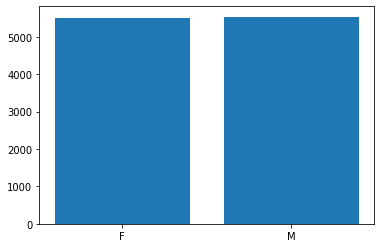

In [410]:
plt.bar(gender_counts['SEX'],gender_counts['CNT'])

As we can see here we have balanced data against the classes 
we have

 




Unique Speakers count

In [411]:
len(files_df.query('ID not in (0,1)')['ID'].unique())

251

Total un-augmented files

We have 251 different speakers

In [412]:
files_df.query('ID not in (0,1)')['ID'].count()

10026

Lets plot males and female sample signals

In [413]:
df = shuffle(files_df).reset_index()
female_sample_files = list(df[df['SEX'] == 'F'].iloc[0:4]['file'])
male_sample_files = list(df[df['SEX'] == 'M'].iloc[0:4]['file'])

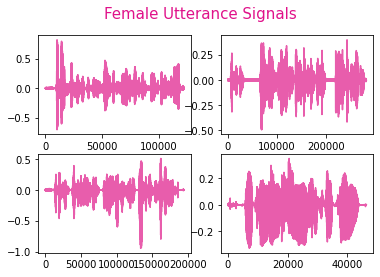

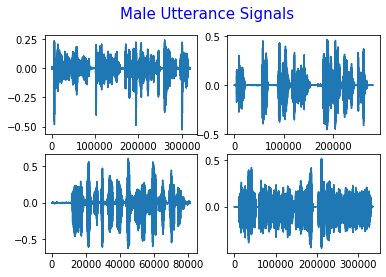

In [414]:
rows = 2
cols = 2
r = 0
c = 0
fig,a =  plt.subplots(rows,cols)
fig.suptitle('Female Utterance Signals', fontsize=15,color='#E0128A')
for i in range(len(female_sample_files)):
  data, sr = librosa.load(female_sample_files[i])
  a[r][c].plot(data,color = '#E85DAC')
  if ( c + 1 == cols ) :
    r += 1
    c = 0
  else:
    c += 1

rows = 2
cols = 2
r = 0
c = 0
fig,a =  plt.subplots(rows,cols)
fig.suptitle('Male Utterance Signals', fontsize=15,color='blue')
for i in range(len(male_sample_files)):
  data, sr = librosa.load(male_sample_files[i])
  a[r][c].plot(data)
  if ( c + 1 == cols ) :
    r += 1
    c = 0
  else:
    c += 1


Lets Plot Spectogram for Male and Female samples

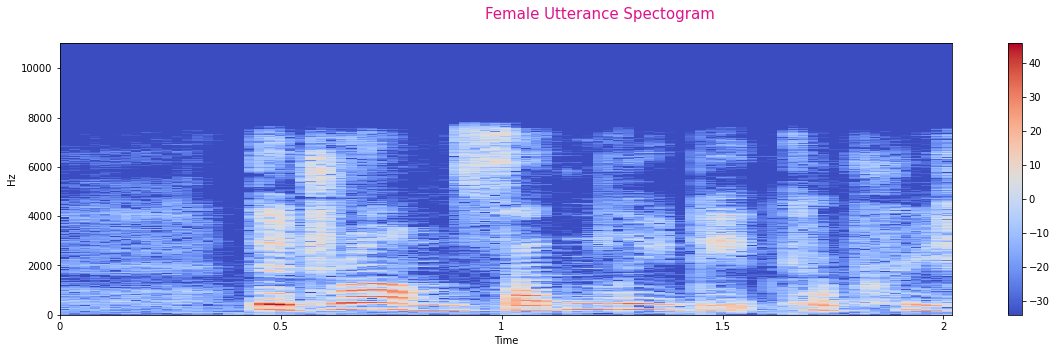

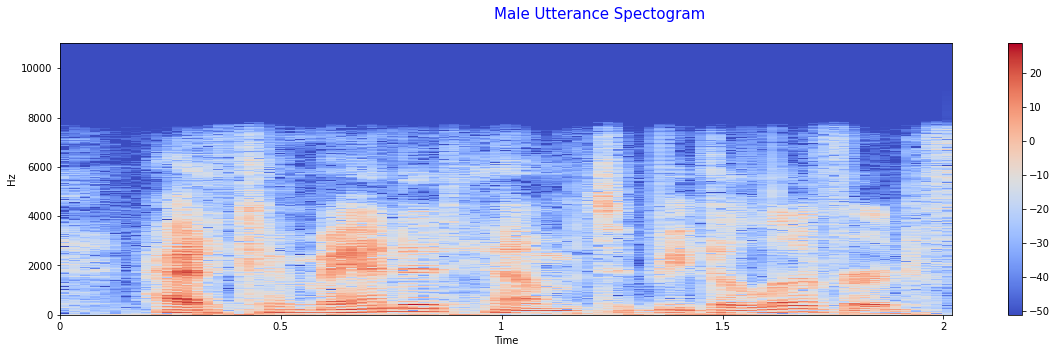

In [415]:
data, sr = librosa.load(female_sample_files[0],duration=duration)
X = librosa.stft(data)
#converting into energy levels(dB)
Xdb = librosa.amplitude_to_db(abs(X))

fig = plt.figure(figsize=(20, 5))
fig.suptitle('Female Utterance Spectogram', fontsize=15,color='#E0128A')
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

data, sr = librosa.load(male_sample_files[0],duration=duration)
X = librosa.stft(data)
#converting into energy levels(dB)
Xdb = librosa.amplitude_to_db(abs(X))

fig = plt.figure(figsize=(20, 5))
fig.suptitle('Male Utterance Spectogram', fontsize=15,color='blue')
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

Lets plot MFCCs for male and female samples

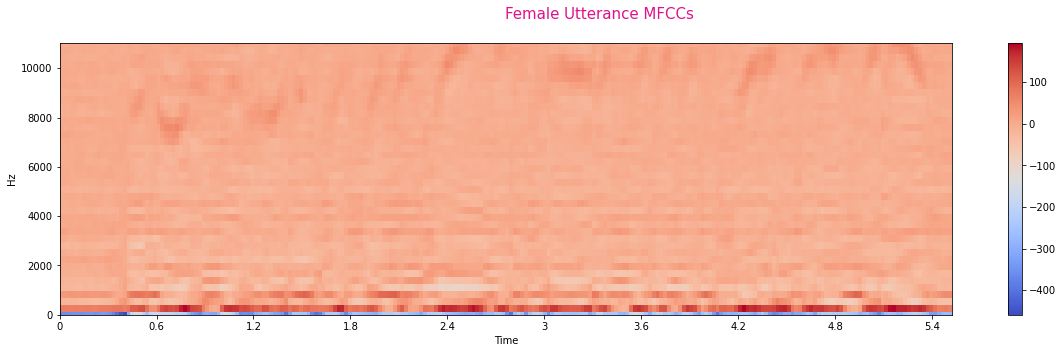

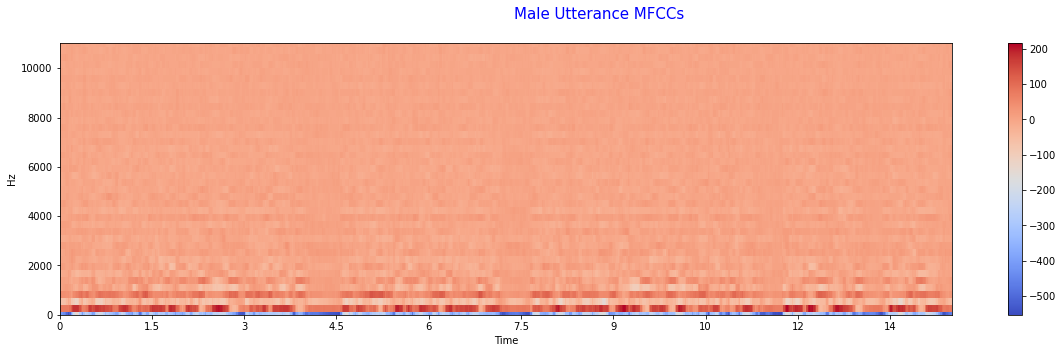

In [416]:
data, sr = librosa.load(female_sample_files[0])
Xdb = get_mfcc_properties(data,sr)
fig = plt.figure(figsize=(20, 5))
fig.suptitle('Female Utterance MFCCs', fontsize=15,color='#E0128A')
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

data, sr = librosa.load(male_sample_files[0])
Xdb = get_mfcc_properties(data,sr)
fig = plt.figure(figsize=(20, 5))
fig.suptitle('Male Utterance MFCCs', fontsize=15,color='blue')
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

Solution 1 :
grab some statistical features from sginal data :


*   zero crossing rates
*   tonal centroid
*   roll-off frequency
*   spectral flattness
*   Spectral Contrast
*   Spectral Bandwidth
*   spectral centroid
*   RMSE



# Approach 1 : Features Statistical Analysis with a Feed Forward Deep Neural Network.

In [417]:
data_df = prepare_stats_df(files_df,url_file_selection=DATA_SOURCE,df_path='data_stats_df.csv')
data_df.to_csv(os.path.join(drive_path,'data_stats_df.csv'),index=False)
gender_labels = data_df['SEX']
labels = [genders.index(x) for x in gender_labels]
data_df = data_df.drop(columns= ['SEX','Unnamed: 0'])

prepare XGboost classifier to calculate feature importanc to select the best features for the calssifier.

In [418]:
sc = StandardScaler()
df_scaled = pd.DataFrame(sc.fit_transform(data_df), columns=data_df.columns)
X_train, X_test, y_train, y_test = train_test_split(df_scaled, labels, test_size=0.33, random_state=7)
# fit model no training data
model = xgboost.XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


Accuracy: 89.84%


In [419]:
dbfile = open('/content/scaler', 'ab') 
pickle.dump(sc, dbfile)                      
dbfile.close()

Get features importance

In [420]:
cols = []
vals = []
a = model.get_booster().get_score(importance_type="gain")
for k in a.keys():
  cols.append(k)
  vals.append(a[k])
importance_df = pd.DataFrame({'col':cols,'importance':vals})
importance_df.sort_values('importance',ascending=False,inplace=True)

In [421]:
# cols_to_keep = importance_df[importance_df['importance'] >= 0]['col'].values.tolist()
df = df_scaled

X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=0.33, random_state=7)

In [422]:
sc = StandardScaler()
df_scaled = pd.DataFrame(sc.fit_transform(data_df), columns=data_df.columns)
X_train, X_test, y_train, y_test = train_test_split(df_scaled, labels, test_size=0.33, random_state=7)
# fit model no training data
model = xgboost.XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 89.84%


In [423]:
dbfile = open('scaler', 'ab') 
pickle.dump(sc, dbfile)                      
dbfile.close() 

In [424]:
def stats_model1():
    model = Sequential()
    model.add(Dense(units=256, activation='relu',input_shape= (X_train.shape[1],)))
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(.4))
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(.4))
    model.add(Dense(units=56, activation='relu'))
    model.add(Dropout(.4))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dense(units=1, activation='sigmoid', name='output_layer'))
    return model

In [425]:
stat_model = stats_model1()
stat_model.compile(loss='binary_crossentropy',
                  optimizer='adam', #tf.keras.optimizers.SGD(lr=1e-4, decay=1e-6, momentum=0.9, nesterov=True),
                  metrics=['accuracy'])  
stat_model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_58 (Dense)             (None, 256)               8448      
_________________________________________________________________
dense_59 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_39 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_60 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_40 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_61 (Dense)             (None, 56)                7224      
_________________________________________________________________
dropout_41 (Dropout)         (None, 56)              

In [426]:
def step_decay(epoch):
    # 00158 = 90.4%
	initial_lrate = 0.01
	drop = 0.9
	epochs_drop = 1
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

In [427]:
early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=4,
                          verbose=2, 
                          mode='auto')
checkpointer = ModelCheckpoint(filepath='model_check.h5', verbose=1, monitor='val_loss', save_best_only=True)
lrate = LearningRateScheduler(step_decay)

In [428]:
history_0 = stat_model.fit(X_train, np.array(y_train), batch_size=20, epochs=120, verbose=1, validation_data=(X_test, np.array(y_test)),callbacks=[early_stopping, checkpointer, lrate ])

Epoch 1/120
41/44 [==========================>...] - ETA: 0s - loss: 0.6635 - accuracy: 0.6122
Epoch 00001: val_loss improved from inf to 0.47700, saving model to model_check.h5
44/44 [==============================] - 0s 11ms/step - loss: 0.6522 - accuracy: 0.6253 - val_loss: 0.4770 - val_accuracy: 0.7783
Epoch 2/120
30/44 [===================>..........] - ETA: 0s - loss: 0.4802 - accuracy: 0.7900
Epoch 00002: val_loss did not improve from 0.47700
44/44 [==============================] - 0s 5ms/step - loss: 0.4960 - accuracy: 0.7916 - val_loss: 0.5172 - val_accuracy: 0.7413
Epoch 3/120
44/44 [==============================] - ETA: 0s - loss: 0.3758 - accuracy: 0.8383
Epoch 00003: val_loss improved from 0.47700 to 0.39222, saving model to model_check.h5
44/44 [==============================] - 0s 6ms/step - loss: 0.3758 - accuracy: 0.8383 - val_loss: 0.3922 - val_accuracy: 0.8499
Epoch 4/120
32/44 [====================>.........] - ETA: 0s - loss: 0.3462 - accuracy: 0.8578
Epoch 00004

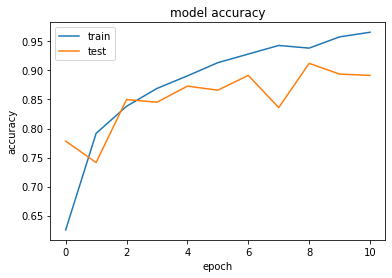

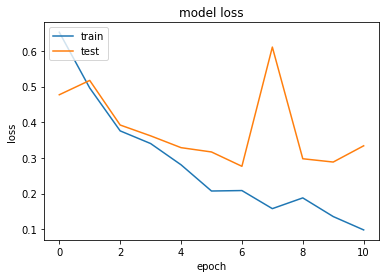

In [429]:
plt.plot(history_0.history['accuracy'])
plt.plot(history_0.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_0.history['loss'])
plt.plot(history_0.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [430]:
other_test_df1 , other_test_labels1 = prepare_other_test_data("test_other/LibriSpeech","test_other/LibriSpeech/SPEAKERS.TXT",'test-other',processing_type='S')

0-33
1-/content/test_other/LibriSpeech/test-other
2-33
3-33
4-1311
5- 1311


KeyboardInterrupt: ignored

Pickle the scaler object to use for future prediction

In [341]:

dbfile = open('/content/scaler', 'rb')      
sc = pickle.load(dbfile) 
dbfile.close() 

df_scaled = pd.DataFrame(sc.transform(other_test_df1), columns=other_test_df1.columns)
df = df_scaled
X_test, X_valid, y_test, y_valid = train_test_split(df, other_test_labels1, test_size=0.1, random_state=7)

In [342]:
other_test_df1.to_csv("/content/drive/My Drive/classification/other_test_df1.csv",index=False)
np.save("/content/drive/My Drive/classification/other_test_labels1.npy",other_test_labels1)

In [360]:
dbfile = open('/content/scaler', 'rb')      
sc = pickle.load(dbfile) 
dbfile.close() 

single_stats_df = prepare_single_stats_df("/content/test_other/LibriSpeech/test-other/6432/63723/6432-63723-0000.flac")
df_scaled = pd.DataFrame(sc.transform(single_stats_df), columns=single_stats_df.columns)
df = df_scaled
pred = model.predict(df)
genders[int(round(pred.reshape(-1)[0]))]

'M'

In [363]:
from sklearn.metrics import f1_score, fbeta_score
y_pred = stat_model.predict(X_test)
df_preds = pd.DataFrame({'y_true':np.array(y_test) , 'y_pred':np.array([int(round(x)) for x in y_pred.reshape(-1)])})
f1_score(df_preds['y_true'], df_preds['y_pred'], average='macro')*100

87.52826968209943

In [364]:
confusion_matrix = pd.crosstab(df_preds['y_true'].map({0:'M',1:'F'}), df_preds['y_pred'].map({0:'M',1:'F'}), rownames=['Actual'], colnames=['Predicted'])
print (np.round(confusion_matrix/len(X_test) * 100,2))

Predicted      F      M
Actual                 
F          43.42   9.47
M           3.00  44.11


# Approach 2 : MFCC features Matrix with 2D Convolution Neural Network.

In [431]:
MODEL_OPTION = 1

Now Lets start building Models

In [432]:
def model1():
    model = Sequential()
    
    model.add(
        Conv1D(filters=16, kernel_size=6, padding='same', activation='relu', data_format='channels_last',
               input_shape=(number_of_mfcc*frames, 1)))

    model.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))

    model.add(
        Conv1D(filters=8, kernel_size=6, padding='same', activation='relu', data_format='channels_last'))
    model.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))

    model.add(
        Conv1D(filters=16, kernel_size=6, padding='same', activation='relu', data_format='channels_last'))
    model.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))

    model.add(
        Conv1D(filters=8, kernel_size=6, padding='same', activation='relu', data_format='channels_last'))
    model.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))


    # model.add(LSTM(256,return_sequences=True))
    model.add(TimeDistributed(Flatten()))
    model.add(Dropout(0.4))
    model.add(Flatten())
    # model.add(Dense(units=512, activation='relu'))
    model.add(Dense(units=256, activation='relu'))
    model.add(Dense(units=1, activation='sigmoid', name='output_layer'))
    return model

In [433]:
def model2():
    model = Sequential()

    model.add(Conv2D(filters=16, kernel_size=(6, 6), strides=(1, 1), input_shape=(number_of_mfcc, frames, 1),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())    

    model.add(Conv2D(filters=16, kernel_size=(6, 6), strides=(1, 1),activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=8, kernel_size=(3, 3), strides=(1, 1),activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())

    # model.add(tf.keras.layers.GaussianNoise(.06))
    # model.add(LSTM(56))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(units=256, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(units=1, activation='sigmoid', name='output_layer'))

    return model

In [434]:
def step_decay(epoch):
    # 00158 = 90.4%
	initial_lrate = 0.00158
	drop = 0.9
	epochs_drop = 1
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

Model 1

In [435]:
early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=2, 
                          mode='auto')
checkpointer = ModelCheckpoint(filepath='model_check1.h5', verbose=1, monitor='val_loss', save_best_only=True)
lrate = LearningRateScheduler(step_decay)

In [436]:
X_train, y_train , X_valid, y_valid, X_test, y_test, files_df = extract_data(files_df,url_file_selection = 'D',extract_type='M',drive_path=drive_path)
X_train = np.reshape(X_train, [len(X_train), number_of_mfcc* frames, 1])
X_valid = np.reshape(X_valid, [len(X_valid), number_of_mfcc* frames, 1])
X_test = np.reshape(X_test, [len(X_test), number_of_mfcc* frames, 1])

In [437]:
model_1 = model1()

model_1.compile(loss='binary_crossentropy',
                  optimizer='adam', #tf.keras.optimizers.SGD(lr=1e-4, decay=1e-6, momentum=0.9, nesterov=True),
                  metrics=['accuracy'])  
model_1.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 3480, 16)          112       
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 1740, 16)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 1740, 8)           776       
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 870, 8)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 870, 16)           784       
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 435, 16)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 435, 8)          

In [438]:
history_1 = model_1.fit(X_train, np.array(y_train), batch_size=20, epochs=120, verbose=1, validation_data=(X_valid, np.array(y_valid)),callbacks=[early_stopping, checkpointer, lrate ])

Epoch 1/120
383/386 [============================>.] - ETA: 0s - loss: 0.3200 - accuracy: 0.8667
Epoch 00001: val_loss improved from inf to 0.22181, saving model to model_check1.h5
386/386 [==============================] - 4s 11ms/step - loss: 0.3193 - accuracy: 0.8669 - val_loss: 0.2218 - val_accuracy: 0.9007
Epoch 2/120
385/386 [============================>.] - ETA: 0s - loss: 0.2434 - accuracy: 0.8891
Epoch 00002: val_loss improved from 0.22181 to 0.21881, saving model to model_check1.h5
386/386 [==============================] - 4s 9ms/step - loss: 0.2434 - accuracy: 0.8892 - val_loss: 0.2188 - val_accuracy: 0.9025
Epoch 3/120
385/386 [============================>.] - ETA: 0s - loss: 0.2222 - accuracy: 0.9004
Epoch 00003: val_loss improved from 0.21881 to 0.21026, saving model to model_check1.h5
386/386 [==============================] - 4s 9ms/step - loss: 0.2224 - accuracy: 0.9002 - val_loss: 0.2103 - val_accuracy: 0.9116
Epoch 4/120
386/386 [==============================] - 

In [439]:
from sklearn.metrics import f1_score, fbeta_score
y_pred = model_1.predict(X_test)
df_preds = pd.DataFrame({'y_true':np.array(y_test) , 'y_pred':np.array([int(round(x)) for x in y_pred.reshape(-1)])})
f1_score(df_preds['y_true'], df_preds['y_pred'], average='macro')*100


89.48176646608135

In [440]:
confusion_matrix = pd.crosstab(df_preds['y_true'].map({0:'M',1:'F'}), df_preds['y_pred'].map({0:'M',1:'F'}), rownames=['Actual'], colnames=['Predicted'])
print (np.round(confusion_matrix/len(X_test) * 100,2))

Predicted      F      M
Actual                 
F          44.15   4.81
M           5.71  45.33


In [441]:
model_1.load_weights('model_check1.h5')

In [442]:
other_test = np.load('/content/drive/My Drive/classification/test_other.npy')
other_test_labels = np.load('/content/drive/My Drive/classification/test_other_labels.npy')
other_test = other_test.reshape(other_test.shape[0],other_test.shape[1]*other_test.shape[2],1)
y_pred = model_1.predict(other_test)
df_preds = pd.DataFrame({'y_true':np.array(other_test_labels) , 'y_pred':np.array([int(round(x)) for x in y_pred.reshape(-1)])})
f1_score(df_preds['y_true'], df_preds['y_pred'], average='macro')*100

87.18544496994593

In [ ]:
save_model_json(drive_path,model,'model_mfcc1')

Training History

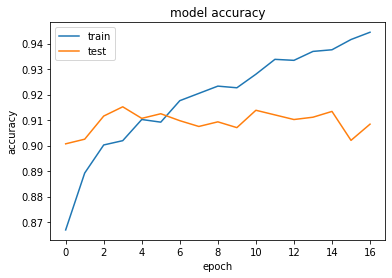

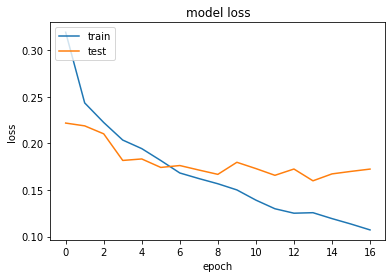

In [443]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Model 2

In [444]:
X_train, y_train , X_valid, y_valid, X_test, y_test, files_df = extract_data(files_df,url_file_selection = 'D',extract_type='M',drive_path=drive_path)
X_train = np.reshape(X_train, [len(X_train), number_of_mfcc, frames, 1])
X_valid = np.reshape(X_valid, [len(X_valid), number_of_mfcc, frames, 1])
X_test = np.reshape(X_test, [len(X_test), number_of_mfcc, frames, 1])

In [445]:
early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=2, 
                          mode='auto')
checkpointer = ModelCheckpoint(filepath='model_check2.h5', verbose=1, monitor='val_loss', save_best_only=True)
lrate = LearningRateScheduler(step_decay)

In [446]:
model_2 = model2()

model_2.compile(loss='binary_crossentropy',
                  optimizer='adam', #tf.keras.optimizers.SGD(lr=1e-4, decay=1e-6, momentum=0.9, nesterov=True),
                  metrics=['accuracy'])  
model_2.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 35, 82, 16)        592       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 18, 41, 16)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 18, 41, 16)        64        
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 13, 36, 16)        9232      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 18, 16)         0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 7, 18, 16)         64        
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 5, 16, 8)        

In [447]:
history_2 = model_2.fit(X_train, np.array(y_train), batch_size=20, epochs=120, verbose=1, validation_data=(X_valid, np.array(y_valid)),callbacks=[early_stopping, checkpointer, lrate ])

Epoch 1/120
381/386 [============================>.] - ETA: 0s - loss: 0.3733 - accuracy: 0.8406
Epoch 00001: val_loss improved from inf to 0.37853, saving model to model_check2.h5
386/386 [==============================] - 3s 9ms/step - loss: 0.3719 - accuracy: 0.8414 - val_loss: 0.3785 - val_accuracy: 0.8458
Epoch 2/120
384/386 [============================>.] - ETA: 0s - loss: 0.2572 - accuracy: 0.8892
Epoch 00002: val_loss improved from 0.37853 to 0.23810, saving model to model_check2.h5
386/386 [==============================] - 3s 8ms/step - loss: 0.2579 - accuracy: 0.8888 - val_loss: 0.2381 - val_accuracy: 0.8785
Epoch 3/120
386/386 [==============================] - ETA: 0s - loss: 0.2201 - accuracy: 0.8976
Epoch 00003: val_loss improved from 0.23810 to 0.21973, saving model to model_check2.h5
386/386 [==============================] - 3s 8ms/step - loss: 0.2201 - accuracy: 0.8976 - val_loss: 0.2197 - val_accuracy: 0.8907
Epoch 4/120
383/386 [============================>.] - E

Plot Training History

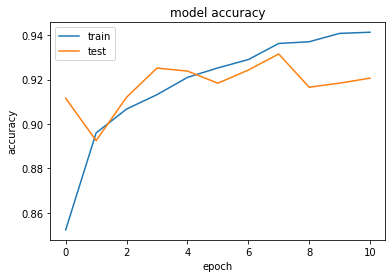

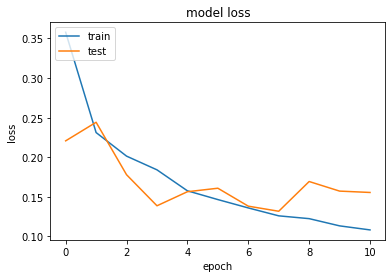

In [448]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [449]:
from sklearn.metrics import f1_score, fbeta_score
y_pred = model_2.predict(X_test)
df_preds = pd.DataFrame({'y_true':np.array(y_test) , 'y_pred':np.array([int(round(x)) for x in y_pred.reshape(-1)])})
f1_score(df_preds['y_true'], df_preds['y_pred'], average='macro')*100


92.65629507978429

In [450]:
confusion_matrix = pd.crosstab(df_preds['y_true'].map({0:'M',1:'F'}), df_preds['y_pred'].map({0:'M',1:'F'}), rownames=['Actual'], colnames=['Predicted'])
print (np.round(confusion_matrix/len(X_test) * 100,2))

Predicted      F      M
Actual                 
F          46.15   2.81
M           4.53  46.51


In [451]:
other_test = np.load('/content/drive/My Drive/classification/test_other.npy')
other_test_labels = np.load('/content/drive/My Drive/classification/test_other_labels.npy')
y_pred = model_2.predict(other_test)
df_preds = pd.DataFrame({'y_true':np.array(other_test_labels) , 'y_pred':np.array([int(round(x)) for x in y_pred.reshape(-1)])})
f1_score(df_preds['y_true'], df_preds['y_pred'], average='macro')*100

87.78907413812436

In [452]:
predict_gender("/content/sp03_street_sn5.wav","3528-168656-0000.flac",model_option=2)

'M'

In [459]:
save_model_json(dir_path=drive_path,model_obj=model_2,model_name='mfcc_model_2')